In [ ]:
# Directorio de trabajo
import sys
import os
from google.colab import drive
drive.mount("/content/drive", force_remount = True)
DIR = "/content/drive/My Drive/bio/"

%cd "$DIR"

In [76]:
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import plot_roc_curve

%matplotlib inline
%load_ext autoreload
%autoreload 2

seed = 2021

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
_ = tf.device('/device:GPU:0')

In [4]:
train_dir = 'UADFV+TIMIT_faces_training/'
test_dir = 'CelebDF-Test/'
top_model_weights = 'models/top-model.h5'
target_size = (160, 160)
input_shape = (160, 160, 3)

In [116]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=20,
    preprocessing_function=tf.keras.applications.vgg19.preprocess_input
)

test_datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=tf.keras.applications.vgg19.preprocess_input
)

train_data = train_datagen.flow_from_directory(
    directory=train_dir,
    class_mode='binary',
    batch_size=16,
    seed=seed,
    target_size=target_size,
)

test_data = test_datagen.flow_from_directory(
    directory=test_dir,
    class_mode='binary',
    batch_size=16,
    shuffle = False,
    seed=seed,
    target_size=target_size,
)

Found 1829 images belonging to 2 classes.
Found 600 images belonging to 2 classes.


In [109]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dropout, Flatten, Dense

# Load pre-trained model
base_model = tf.keras.applications.VGG19(
    include_top=False,
    weights="imagenet",
    input_shape=input_shape,
    pooling='avg',
)
base_model.trainable = False

x = base_model.output

# Create top model
x = Dense(512, activation='relu')(x)
x = Dropout(0.25)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(base_model.input, outputs)

model.summary()

Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        [(None, 160, 160, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 160, 160, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 160, 160, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 80, 80, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 80, 80, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 80, 80, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 40, 40, 128)       0  

In [110]:
# Compile model
metric = tf.keras.metrics.AUC(name='auc')
loss = 'binary_crossentropy'

model.compile(loss=loss,
              optimizer='rmsprop',
              metrics=[metric])

## Step 1: train only top model

In [111]:
history = model.fit(
    train_data,
    epochs=3,
)

Epoch 1/3
115/115 [==============================] - 15s 123ms/step - loss: 0.7507 - auc: 0.5120
Epoch 2/3
115/115 [==============================] - 14s 122ms/step - loss: 0.6776 - auc: 0.6005
Epoch 3/3
115/115 [==============================] - 14s 121ms/step - loss: 0.6204 - auc: 0.6847


## Step 2: unfreeze some layers and train with small learning rate

In [112]:
# Unfreeze some of the base model layers
for layer in base_model.layers[17:]:
    layer.trainable = True

# Compile model
metric = tf.keras.metrics.AUC(name='auc')
sgd=tf.keras.optimizers.SGD(lr=5e-4, momentum=0.9)

model.compile(loss='binary_crossentropy',
              optimizer=sgd,
              metrics=[metric])

In [113]:
history = model.fit(
    train_data,
    epochs=15,
)

Epoch 1/15
115/115 [==============================] - 15s 127ms/step - loss: 0.5782 - auc: 0.7457
Epoch 2/15
115/115 [==============================] - 14s 125ms/step - loss: 0.4016 - auc: 0.8972
Epoch 3/15
115/115 [==============================] - 15s 126ms/step - loss: 0.3240 - auc: 0.9368
Epoch 4/15
115/115 [==============================] - 14s 125ms/step - loss: 0.1990 - auc: 0.9752
Epoch 5/15
115/115 [==============================] - 15s 129ms/step - loss: 0.1747 - auc: 0.9808
Epoch 6/15
115/115 [==============================] - 14s 125ms/step - loss: 0.1233 - auc: 0.9908
Epoch 7/15
115/115 [==============================] - 15s 131ms/step - loss: 0.0964 - auc: 0.9948
Epoch 8/15
115/115 [==============================] - 15s 126ms/step - loss: 0.1334 - auc: 0.9889
Epoch 9/15
115/115 [==============================] - 14s 125ms/step - loss: 0.0663 - auc: 0.9966
Epoch 10/15
115/115 [==============================] - 15s 127ms/step - loss: 0.1631 - auc: 0.9832
Epoch 11/15
115/115

In [118]:
_ , auc_test = model.evaluate(test_data)

38/38 [==============================] - 2s 49ms/step - loss: 1.1641 - auc: 0.8107


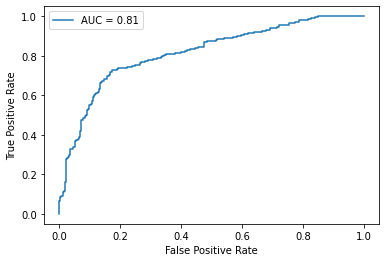

In [119]:
from sklearn.metrics import roc_curve

y_pred = model.predict(test_data).ravel()
fpr, tpr, _ = roc_curve(test_data.classes, y_pred)
plt.plot(fpr, tpr, label=f"AUC = {auc_test:.2f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()